In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re

# --- CONFIGURATION ---
VECTOR_LOG_DIR = "logs/vectors_and_scores"
OUTPUT_DIR = "visualizations/shared_similarity"
MAX_VIS_POS = 10000
os.makedirs(OUTPUT_DIR, exist_ok=True)
START_LAYER = 59

def compute_cosine_similarity_matrix(vectors):
    """
    Computes the T x T cosine similarity matrix.
    Formula: Sim(i,j) = (v_i . v_j) / (||v_i|| * ||v_j||)
    """
    # 1. L2 Normalize vectors (axis=1) to unit length
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    normalized_vectors = vectors / norms
    
    # 2. Compute Dot Product -> Cosine Similarity
    sim_matrix = np.dot(normalized_vectors, normalized_vectors.T)
    return sim_matrix

def parse_and_group_files(log_dir):
    groups = {}
    # Keep the regex simple to reliably capture ANY number
    pattern = re.compile(r"layer_(\d+)_keys_(index|attn)_h_(\d+)\.csv")
    
    files = glob.glob(os.path.join(log_dir, "*.csv"))
    print(f"Found {len(files)} CSV files in {log_dir}")
    
    skipped_count = 0
    
    for f in files:
        basename = os.path.basename(f)
        match = pattern.match(basename)
        if match:
            layer_id = int(match.group(1))
            
            # --- NEW: RESUME LOGIC ---
            if layer_id < START_LAYER:
                skipped_count += 1
                continue
            # -------------------------

            type_str = match.group(2) # 'index' or 'attn'
            
            if layer_id not in groups:
                groups[layer_id] = {'index': [], 'attn': []}
            groups[layer_id][type_str].append(f)
            
    print(f"Skipped {skipped_count} files (Layer < {START_LAYER})")
    print(f"Queued {len(groups)} layers for processing (Layer >= {START_LAYER})")
            
    return groups

def plot_triangular_heatmap(matrix, title, filename):
    plt.figure(figsize=(14, 11))
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(matrix), k=1)
    
    sns.heatmap(
        matrix, 
        cmap="Greys", 
        # vmin=0.0, vmax=1.0,  # Clip negatives to white, max similarity to black
        cbar_kws={'label': 'Cosine Similarity'},
        xticklabels=max(1, len(matrix)//10), 
        yticklabels=max(1, len(matrix)//10),
        square=True,
        mask=mask  # Apply the triangular mask
    )
    
    plt.title(title, fontsize=15)
    plt.xlabel("Key Token Position (s)", fontsize=12)
    plt.ylabel("Key Token Position (t)", fontsize=12)
    
    save_path = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: {save_path}")

def normalize_matrix_for_aggregation(matrix):
    """Min-Max normalization to [0,1]"""
    m_min, m_max = np.nanmin(matrix), np.nanmax(matrix)
    denom = m_max - m_min
    if denom == 0: denom = 1
    return (matrix - m_min) / denom

# --- MAIN EXECUTION ---

layer_groups = parse_and_group_files(VECTOR_LOG_DIR)
sorted_layers = sorted(layer_groups.keys())

global_index_matrices = []
global_attn_matrices = []

for layer_id in sorted_layers:
    print(f"Processing Layer {layer_id}...")
    
    # PROCESS INDEXER
    if layer_groups[layer_id]['index']:
        head_dfs = [pd.read_csv(f, index_col=0).replace(r'^\s*$', np.nan, regex=True).astype(float) for f in layer_groups[layer_id]['index']]
        if head_dfs:
            # Concat all heads
            concat_keys = pd.concat([df.iloc[:MAX_VIS_POS] for df in head_dfs], axis=1).values
            sim_matrix = compute_cosine_similarity_matrix(concat_keys)
            
            plot_triangular_heatmap(
                sim_matrix, 
                f"Layer {layer_id} Indexer Shared Similarity (Lower Triangular)", 
                f"layer_{layer_id}_indexer_triangular.png"
            )
            global_index_matrices.append(normalize_matrix_for_aggregation(sim_matrix))

    # PROCESS ATTENTION
    if layer_groups[layer_id]['attn']:
        head_dfs = [pd.read_csv(f, index_col=0).replace(r'^\s*$', np.nan, regex=True).astype(float) for f in layer_groups[layer_id]['attn']]
        if head_dfs:
            concat_keys = pd.concat([df.iloc[:MAX_VIS_POS] for df in head_dfs], axis=1).values
            sim_matrix = compute_cosine_similarity_matrix(concat_keys)
            
            plot_triangular_heatmap(
                sim_matrix, 
                f"Layer {layer_id} Attention Shared Similarity (Lower Triangular)", 
                f"layer_{layer_id}_attn_triangular.png"
            )
            global_attn_matrices.append(normalize_matrix_for_aggregation(sim_matrix))

# --- GLOBAL AGGREGATION ---
print("\nGenerating Global Consensus Maps...")

if global_index_matrices:
    avg_index = np.nanmean(np.stack(global_index_matrices), axis=0)
    plot_triangular_heatmap(
        avg_index, 
        "Global Indexer Consensus (Lower Triangular)", 
        "GLOBAL_indexer_consensus_triangular.png"
    )

if global_attn_matrices:
    avg_attn = np.nanmean(np.stack(global_attn_matrices), axis=0)
    plot_triangular_heatmap(
        avg_attn, 
        "Global Attention Consensus (Lower Triangular)", 
        "GLOBAL_attn_consensus_triangular.png"
    )

Found 23546 CSV files in logs/vectors_and_scores
Skipped 11328 files (Layer < 59)
Queued 2 layers for processing (Layer >= 59)
Processing Layer 59...
Saved: visualizations/shared_similarity/layer_59_indexer_triangular.png
Saved: visualizations/shared_similarity/layer_59_attn_triangular.png
Processing Layer 60...
Saved: visualizations/shared_similarity/layer_60_indexer_triangular.png
Saved: visualizations/shared_similarity/layer_60_attn_triangular.png

Generating Global Consensus Maps...
Saved: visualizations/shared_similarity/GLOBAL_indexer_consensus_triangular.png
Saved: visualizations/shared_similarity/GLOBAL_attn_consensus_triangular.png


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
import gc  # Garbage Collection

# --- CONFIGURATION ---
VECTOR_LOG_DIR = "logs/vectors_and_scores"
OUTPUT_DIR = "visualizations/shared_similarity"
# MAX_VIS_POS = 1024
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- HELPER FUNCTIONS ---

def compute_cosine_similarity_matrix(vectors):
    """Computes T x T cosine similarity from (T, D) vectors."""
    # L2 Normalize
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    normalized_vectors = vectors / norms
    # Dot Product
    return np.dot(normalized_vectors, normalized_vectors.T)

def normalize_min_max(matrix):
    """Normalize matrix to [0, 1] range."""
    m_min, m_max = np.nanmin(matrix), np.nanmax(matrix)
    denom = m_max - m_min
    if denom == 0: denom = 1
    return (matrix - m_min) / denom

def plot_triangular_heatmap(matrix, title, filename):
    plt.figure(figsize=(14, 11))
    mask = np.triu(np.ones_like(matrix), k=1)
    
    sns.heatmap(
        matrix, 
        cmap="Greys", 
        vmin=0.0, vmax=1.0,
        cbar_kws={'label': 'Cosine Similarity'},
        xticklabels=max(1, len(matrix)//10), 
        yticklabels=max(1, len(matrix)//10),
        square=True,
        mask=mask
    )
    
    plt.title(title, fontsize=15)
    plt.xlabel("Key Token Position (s)", fontsize=12)
    plt.ylabel("Key Token Position (t)", fontsize=12)
    
    save_path = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: {save_path}")

def parse_all_layers(log_dir):
    groups = {}
    pattern = re.compile(r"layer_(\d+)_keys_(index|attn)_h_(\d+)\.csv")
    files = glob.glob(os.path.join(log_dir, "*.csv"))
    
    print(f"Scanning {len(files)} total files...")
    
    for f in files:
        match = pattern.match(os.path.basename(f))
        if match:
            layer_id = int(match.group(1))
            type_str = match.group(2)
            if layer_id not in groups: groups[layer_id] = {'index': [], 'attn': []}
            groups[layer_id][type_str].append(f)
            
    return groups

# --- MAIN AGGREGATION LOGIC (RUNNING MEAN) ---

layer_groups = parse_all_layers(VECTOR_LOG_DIR)
sorted_layers = sorted(layer_groups.keys())

print(f"Found layers: {sorted_layers}")

# Initialize Accumulators for Running Mean
# We don't know the shape yet, so we init as None
global_index_sum = None
global_index_count = 0

global_attn_sum = None
global_attn_count = 0

for layer_id in sorted_layers:
    print(f"Aggregating Layer {layer_id}...", end=" ", flush=True)
    
    # ---------------------------
    # 1. PROCESS INDEXER HEADS
    # ---------------------------
    idx_files = layer_groups[layer_id]['index']
    if idx_files:
        try:
            # Load and Concat
            head_dfs = [pd.read_csv(f, index_col=0).replace(r'^\s*$', np.nan, regex=True).astype(float) for f in idx_files]
            if head_dfs:
                concat_keys = pd.concat([df.iloc[:MAX_VIS_POS] for df in head_dfs], axis=1).values
                
                # Compute Sim & Normalize
                sim_matrix = compute_cosine_similarity_matrix(concat_keys)
                norm_matrix = normalize_min_max(sim_matrix)
                
                # Add to Running Sum
                if global_index_sum is None:
                    global_index_sum = np.nan_to_num(norm_matrix)
                else:
                    global_index_sum += np.nan_to_num(norm_matrix)
                global_index_count += 1
                
                # Optional: Save individual layer plot if needed (commented out to save time)
                # plot_triangular_heatmap(norm_matrix, f"Layer {layer_id} Indexer", f"layer_{layer_id}_index.png")
        except Exception as e:
            print(f"[Error Index L{layer_id}: {e}]", end=" ")

    # ---------------------------
    # 2. PROCESS ATTENTION HEADS
    # ---------------------------
    attn_files = layer_groups[layer_id]['attn']
    if attn_files:
        try:
            head_dfs = [pd.read_csv(f, index_col=0).replace(r'^\s*$', np.nan, regex=True).astype(float) for f in attn_files]
            if head_dfs:
                concat_keys = pd.concat([df.iloc[:MAX_VIS_POS] for df in head_dfs], axis=1).values
                
                sim_matrix = compute_cosine_similarity_matrix(concat_keys)
                norm_matrix = normalize_min_max(sim_matrix)
                
                if global_attn_sum is None:
                    global_attn_sum = np.nan_to_num(norm_matrix)
                else:
                    global_attn_sum += np.nan_to_num(norm_matrix)
                global_attn_count += 1
        except Exception as e:
            print(f"[Error Attn L{layer_id}: {e}]", end=" ")

    print("Done.")
    
    # CRITICAL: Force Garbage Collection to prevent RAM explosion
    del head_dfs, concat_keys, sim_matrix, norm_matrix
    gc.collect()

# --- FINAL PLOTTING ---
print("\nComputing Final Averages...")

if global_index_sum is not None and global_index_count > 0:
    final_index_mean = global_index_sum / global_index_count
    plot_triangular_heatmap(
        final_index_mean, 
        f"GLOBAL Indexer Consensus\n(Aggregated over {global_index_count} layers)", 
        "GLOBAL_indexer_consensus_triangular_ALL.png"
    )
else:
    print("No Indexer data found to aggregate.")

if global_attn_sum is not None and global_attn_count > 0:
    final_attn_mean = global_attn_sum / global_attn_count
    plot_triangular_heatmap(
        final_attn_mean, 
        f"GLOBAL Attention Consensus\n(Aggregated over {global_attn_count} layers)", 
        "GLOBAL_attn_consensus_triangular_ALL.png"
    )
else:
    print("No Attention data found to aggregate.")

print("\nProcess Complete.")

Scanning 23546 total files...
Found layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
Aggregating Layer 0... Done.
Aggregating Layer 1... Done.
Aggregating Layer 2... Done.
Aggregating Layer 3... Done.
Aggregating Layer 4... Done.
Aggregating Layer 5... Done.
Aggregating Layer 6... Done.
Aggregating Layer 7... Done.
Aggregating Layer 8... Done.
Aggregating Layer 9... Done.
Aggregating Layer 10... Done.
Aggregating Layer 11... Done.
Aggregating Layer 12... Done.
Aggregating Layer 13... Done.
Aggregating Layer 14... Done.
Aggregating Layer 15... Done.
Aggregating Layer 16... Done.
Aggregating Layer 17... Done.
Aggregating Layer 18... Done.
Aggregating Layer 19... Done.
Aggregating Layer 20... Done.
Aggregating Layer 21... Done.
Aggregating Layer 22... Done.
Aggregating Layer 23... Done.
Aggregating

Scanning 23546 files in /home/f50056118/DS-V3.2-Indexer-Viz/logs/vectors_and_scores/...
Aggregating 61 layers (Incrementally)...
Processing Layer 0... Done.
Processing Layer 1... Done.
Processing Layer 2... Done.
Processing Layer 3... Done.
Processing Layer 4... Done.
Processing Layer 5... Done.
Processing Layer 6... Done.
Processing Layer 7... Done.
Processing Layer 8... Done.
Processing Layer 9... Done.
Processing Layer 10... Done.
Processing Layer 11... Done.
Processing Layer 12... Done.
Processing Layer 13... Done.
Processing Layer 14... Done.
Processing Layer 15... Done.
Processing Layer 16... Done.
Processing Layer 17... Done.
Processing Layer 18... Done.
Processing Layer 19... Done.
Processing Layer 20... Done.
Processing Layer 21... Done.
Processing Layer 22... Done.
Processing Layer 23... Done.
Processing Layer 24... Done.
Processing Layer 25... Done.
Processing Layer 26... Done.
Processing Layer 27... Done.
Processing Layer 28... Done.
Processing Layer 29... Done.
Processing 

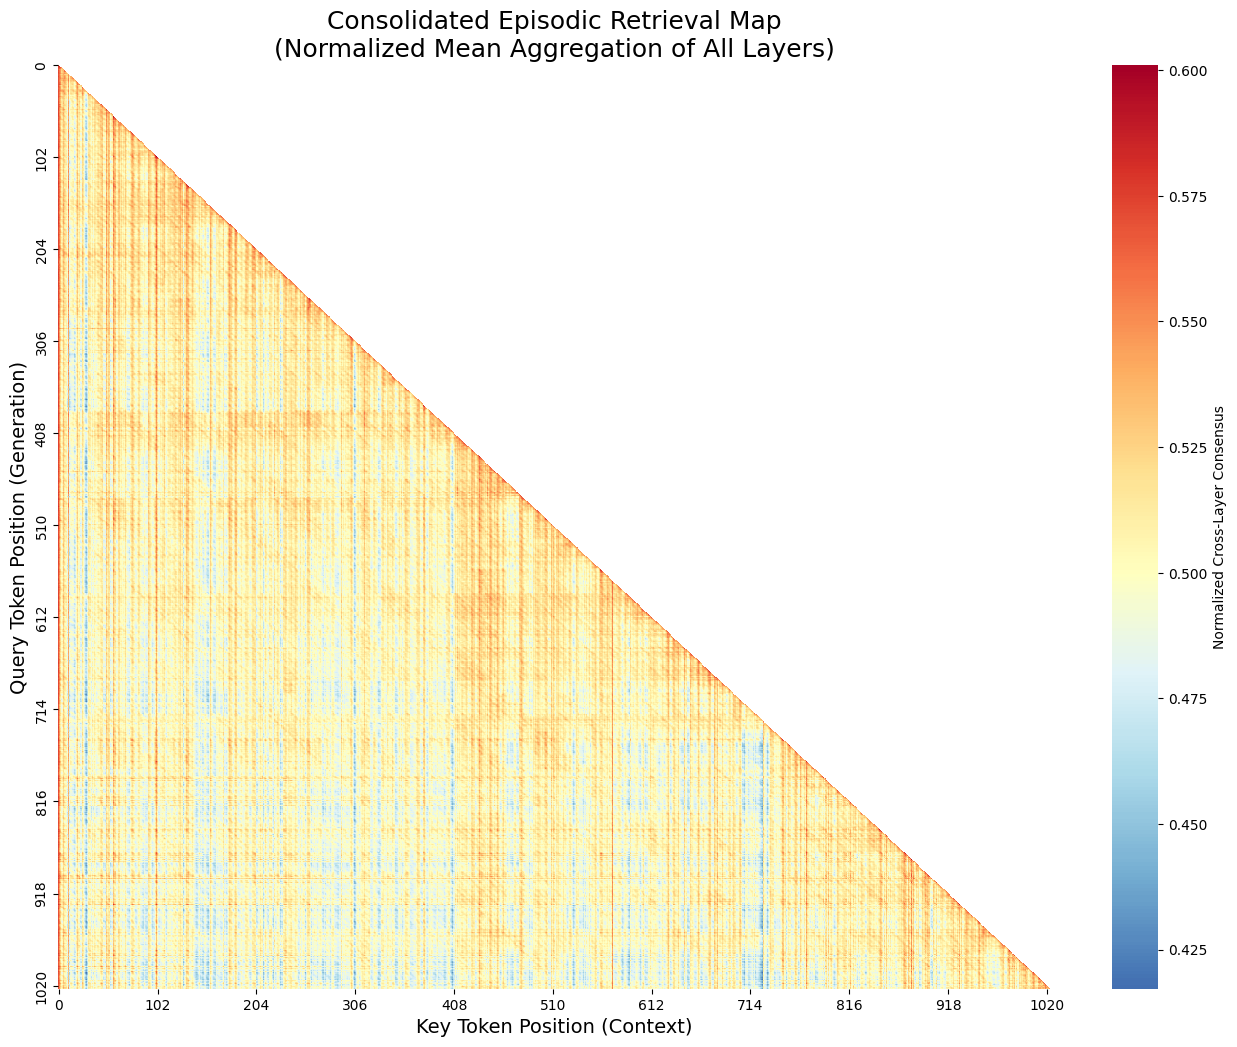

Aggregated visualization saved to visualizations/indexer_consensus/aggregated_episodic_map_final.png


In [7]:
LOG_DIR = "/home/f50056118/DS-V3.2-Indexer-Viz/logs/vectors_and_scores/"
OUTPUT_DIR = "visualizations/indexer_consensus"
os.makedirs(OUTPUT_DIR, exist_ok=True)
def parse_index_score_files(log_dir):
    """
    Parses files matching the format: layer_{id}_activations_index.csv
    Returns a dict: {layer_id: filepath}
    """
    layer_files = {}
    pattern = re.compile(r"layer_(\d+)_activations_index\.csv")
    
    if not os.path.exists(log_dir):
        print(f"Error: Directory {log_dir} does not exist.")
        return {}

    files = glob.glob(os.path.join(log_dir, "*.csv"))
    print(f"Scanning {len(files)} files in {log_dir}...")
    
    for f in files:
        basename = os.path.basename(f)
        match = pattern.match(basename)
        if match:
            layer_id = int(match.group(1))
            layer_files[layer_id] = f
            
    return layer_files

def normalize_layer(matrix):
    """
    Replicates your exact normalization logic:
    Min-Max scaling to [0, 1] per layer.
    """
    m_min = np.nanmin(matrix)
    m_max = np.nanmax(matrix)
    denom = m_max - m_min
    if denom == 0: denom = 1
    return (matrix - m_min) / denom

# --- MAIN AGGREGATION LOGIC (MEMORY SAFE) ---

layer_map = parse_index_score_files(LOG_DIR)
sorted_layers = sorted(layer_map.keys())

if not sorted_layers:
    print("No files found matching the pattern.")
else:
    print(f"Aggregating {len(sorted_layers)} layers (Incrementally)...")
    
    global_sum = None
    global_count = 0

    for layer_id in sorted_layers:
        filepath = layer_map[layer_id]
        print(f"Processing Layer {layer_id}...", end=" ", flush=True)
        
        try:
            # 1. Load
            df = pd.read_csv(filepath, index_col=0)
            df = df.replace(r'^\s*$', np.nan, regex=True).astype(float)
            
            # 2. Crop
            if MAX_VIS_POS:
                df = df.iloc[:MAX_VIS_POS, :MAX_VIS_POS]
            
            matrix = df.values
            
            # 3. Normalize (Your Logic)
            norm_matrix = normalize_layer(matrix)
            
            # 4. Accumulate (Running Sum)
            # We use nan_to_num to treat NaNs as 0 during summation if shapes match, 
            # but ideally we want to preserve NaNs if they are consistently NaN.
            # Here we assume standard matrix addition.
            if global_sum is None:
                global_sum = np.nan_to_num(norm_matrix)
            else:
                global_sum += np.nan_to_num(norm_matrix)
            
            global_count += 1
            print("Done.")

        except Exception as e:
            print(f"[Error: {e}]")
        
        # 5. Garbage Collection (Critical for preventing kernel death)
        del df, matrix, norm_matrix
        gc.collect()

    # --- PLOTTING ---
    if global_count > 0:
        print("\nComputing final mean...")
        # Calculate Mean
        aggregated_matrix = global_sum / global_count
        
        print("Generating Heatmap...")
        plt.figure(figsize=(16, 12))
        
        # Using the specific style you requested
        sns.heatmap(
            aggregated_matrix,
            cmap="RdYlBu_r",   # Red-Yellow-Blue (reversed)
            center=0.5,        # Center at 0.5 since data is [0, 1]
            cbar_kws={'label': 'Normalized Cross-Layer Consensus'},
            xticklabels=max(1, len(aggregated_matrix)//10),
            yticklabels=max(1, len(aggregated_matrix)//10),
            # Mask 0s if they were originally NaNs (optional, effectively handled by nan_to_num=0)
            # or specifically mask actual 0s if that denotes 'no data'
            mask=(aggregated_matrix == 0) 
        )

        plt.title("Consolidated Episodic Retrieval Map\n(Normalized Mean Aggregation of All Layers)", fontsize=18)
        plt.xlabel("Key Token Position (Context)", fontsize=14)
        plt.ylabel("Query Token Position (Generation)", fontsize=14)
        
        save_path = os.path.join(OUTPUT_DIR, "aggregated_episodic_map_final.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Aggregated visualization saved to {save_path}")
    else:
        print("Aggregation failed: No valid data processed.")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
import gc  # Garbage Collection

# --- CONFIGURATION ---
VECTOR_LOG_DIR = "logs/vector_logs"
OUTPUT_DIR = "visualizations/shared_similarity"
MAX_VIS_POS = 1024
# The similarity score (0.0 to 1.0) below which a boundary is triggered
SIMILARITY_THRESHOLD = 0.45 
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- HELPER FUNCTIONS ---

def compute_cosine_similarity_matrix(vectors):
    """Computes T x T cosine similarity from (T, D) vectors."""
    # L2 Normalize
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    normalized_vectors = vectors / norms
    # Dot Product
    return np.dot(normalized_vectors, normalized_vectors.T)

def normalize_min_max(matrix):
    """Normalize matrix to [0, 1] range."""
    m_min, m_max = np.nanmin(matrix), np.nanmax(matrix)
    denom = m_max - m_min
    if denom == 0: denom = 1
    return (matrix - m_min) / denom

def detect_boundaries_from_matrix(matrix, threshold):
    """
    Detects event boundaries based on the aggregated similarity matrix.
    Logic: A boundary occurs at 't' if the similarity to 't-1' drops below threshold.
    This approximates the 'v_t > T_sim' logic from the notebook using the matrix diagonal.
    """
    T = matrix.shape[0]
    boundaries = []
    
    # We look at the first off-diagonal (similarity of t with t-1)
    # offset=-1 gives [Sim(1,0), Sim(2,1), Sim(3,2), ...]
    off_diag = np.diagonal(matrix, offset=-1)
    
    # Check for drops
    # i corresponds to t=1, t=2... so boundary index is i+1
    for i, score in enumerate(off_diag):
        # If similarity to immediate past is too low, it's a boundary start
        if score < threshold:
            boundaries.append(i + 1)
            
    return boundaries

def plot_triangular_heatmap(matrix, title, filename, boundaries=None):
    plt.figure(figsize=(14, 11))
    mask = np.triu(np.ones_like(matrix), k=1)
    
    # Plot Heatmap
    sns.heatmap(
        matrix, 
        cmap="Greys", 
        vmin=0.0, vmax=1.0,
        cbar_kws={'label': 'Cosine Similarity'},
        xticklabels=max(1, len(matrix)//10), 
        yticklabels=max(1, len(matrix)//10),
        square=True,
        mask=mask
    )
    
    # --- NEW: VISUALISE BOUNDARIES ---
    if boundaries:
        for b in boundaries:
            # Draw vertical and horizontal lines for the boundary
            # We use distinct red dashed lines
            plt.axvline(x=b, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
            plt.axhline(y=b, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
            
        # Add a dummy plot for the legend
        plt.plot([], [], color='red', linestyle='--', label=f'Event Boundary (Thresh={SIMILARITY_THRESHOLD})')
        plt.legend(loc='upper right', fontsize=12, framealpha=1.0)
    # ---------------------------------

    plt.title(title, fontsize=15)
    plt.xlabel("Key Token Position (s)", fontsize=12)
    plt.ylabel("Key Token Position (t)", fontsize=12)
    
    save_path = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: {save_path}")

def parse_all_layers(log_dir):
    groups = {}
    pattern = re.compile(r"layer_(\d+)_keys_(index|attn)_h_(\d+)\.csv")
    files = glob.glob(os.path.join(log_dir, "*.csv"))
    
    print(f"Scanning {len(files)} total files...")
    
    for f in files:
        match = pattern.match(os.path.basename(f))
        if match:
            layer_id = int(match.group(1))
            type_str = match.group(2)
            if layer_id not in groups: groups[layer_id] = {'index': [], 'attn': []}
            groups[layer_id][type_str].append(f)
            
    return groups

# --- MAIN AGGREGATION LOGIC (RUNNING MEAN) ---

layer_groups = parse_all_layers(VECTOR_LOG_DIR)
sorted_layers = sorted(layer_groups.keys())

print(f"Found layers: {sorted_layers}")

global_index_sum = None
global_index_count = 0

global_attn_sum = None
global_attn_count = 0

for layer_id in sorted_layers:
    print(f"Aggregating Layer {layer_id}...", end=" ", flush=True)
    
    # 1. PROCESS INDEXER HEADS
    idx_files = layer_groups[layer_id]['index']
    if idx_files:
        try:
            head_dfs = [pd.read_csv(f, index_col=0).replace(r'^\s*$', np.nan, regex=True).astype(float) for f in idx_files]
            if head_dfs:
                concat_keys = pd.concat([df.iloc[:MAX_VIS_POS] for df in head_dfs], axis=1).values
                sim_matrix = compute_cosine_similarity_matrix(concat_keys)
                norm_matrix = normalize_min_max(sim_matrix)
                
                if global_index_sum is None:
                    global_index_sum = np.nan_to_num(norm_matrix)
                else:
                    global_index_sum += np.nan_to_num(norm_matrix)
                global_index_count += 1
        except Exception as e:
            print(f"[Error Index L{layer_id}: {e}]", end=" ")

    # 2. PROCESS ATTENTION HEADS
    attn_files = layer_groups[layer_id]['attn']
    if attn_files:
        try:
            head_dfs = [pd.read_csv(f, index_col=0).replace(r'^\s*$', np.nan, regex=True).astype(float) for f in attn_files]
            if head_dfs:
                concat_keys = pd.concat([df.iloc[:MAX_VIS_POS] for df in head_dfs], axis=1).values
                sim_matrix = compute_cosine_similarity_matrix(concat_keys)
                norm_matrix = normalize_min_max(sim_matrix)
                
                if global_attn_sum is None:
                    global_attn_sum = np.nan_to_num(norm_matrix)
                else:
                    global_attn_sum += np.nan_to_num(norm_matrix)
                global_attn_count += 1
        except Exception as e:
            print(f"[Error Attn L{layer_id}: {e}]", end=" ")

    print("Done.")
    del head_dfs, concat_keys, sim_matrix, norm_matrix
    gc.collect()

# --- FINAL PLOTTING WITH BOUNDARIES ---
print("\nComputing Final Averages and Boundaries...")

if global_index_sum is not None and global_index_count > 0:
    final_index_mean = global_index_sum / global_index_count
    
    # DETECT BOUNDARIES
    idx_boundaries = detect_boundaries_from_matrix(final_index_mean, SIMILARITY_THRESHOLD)
    print(f"Detected {len(idx_boundaries)} event boundaries in Indexer Consensus.")
    
    plot_triangular_heatmap(
        final_index_mean, 
        f"GLOBAL Indexer Consensus (Aggregated over {global_index_count} layers)", 
        "GLOBAL_indexer_consensus_triangular_ALL.png",
        boundaries=idx_boundaries
    )
else:
    print("No Indexer data found.")

if global_attn_sum is not None and global_attn_count > 0:
    final_attn_mean = global_attn_sum / global_attn_count
    
    # DETECT BOUNDARIES
    attn_boundaries = detect_boundaries_from_matrix(final_attn_mean, SIMILARITY_THRESHOLD)
    print(f"Detected {len(attn_boundaries)} event boundaries in Attention Consensus.")
    
    plot_triangular_heatmap(
        final_attn_mean, 
        f"GLOBAL Attention Consensus (Aggregated over {global_attn_count} layers)", 
        "GLOBAL_attn_consensus_triangular_ALL.png",
        boundaries=attn_boundaries
    )
else:
    print("No Attention data found.")

print("\nProcess Complete.")

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import re
import gc

# --- CONFIGURATION ---
VECTOR_LOG_DIR = "logs/vectors_and_scores"
PROCESSED_DIR = "processed_data"  # New folder for the aggregated result
MAX_VIS_POS = 10000
os.makedirs(PROCESSED_DIR, exist_ok=True)

def compute_cosine_similarity_matrix(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    normalized_vectors = vectors / norms
    return np.dot(normalized_vectors, normalized_vectors.T)

def normalize_min_max(matrix):
    m_min, m_max = np.nanmin(matrix), np.nanmax(matrix)
    denom = m_max - m_min
    if denom == 0: denom = 1
    return (matrix - m_min) / denom

def parse_all_layers(log_dir):
    groups = {}
    pattern = re.compile(r"layer_(\d+)_keys_(index|attn)_h_(\d+)\.csv")
    files = glob.glob(os.path.join(log_dir, "*.csv"))
    print(f"Scanning {len(files)} total files...")
    for f in files:
        match = pattern.match(os.path.basename(f))
        if match:
            layer_id = int(match.group(1))
            type_str = match.group(2)
            if layer_id not in groups: groups[layer_id] = {'index': [], 'attn': []}
            groups[layer_id][type_str].append(f)
    return groups

# --- AGGREGATION LOGIC ---
layer_groups = parse_all_layers(VECTOR_LOG_DIR)
sorted_layers = sorted(layer_groups.keys())

global_index_sum = None
global_index_count = 0
global_attn_sum = None
global_attn_count = 0

print(f"Aggregating {len(sorted_layers)} layers...")

for layer_id in sorted_layers:
    print(f"L{layer_id}", end=" ", flush=True)
    
    # Indexer
    if layer_groups[layer_id]['index']:
        try:
            head_dfs = [pd.read_csv(f, index_col=0).replace(r'^\s*$', np.nan, regex=True).astype(float) for f in layer_groups[layer_id]['index']]
            if head_dfs:
                concat_keys = pd.concat([df.iloc[:MAX_VIS_POS] for df in head_dfs], axis=1).values
                sim = normalize_min_max(compute_cosine_similarity_matrix(concat_keys))
                global_index_sum = np.nan_to_num(sim) if global_index_sum is None else global_index_sum + np.nan_to_num(sim)
                global_index_count += 1
        except Exception: pass

    # Attention
    if layer_groups[layer_id]['attn']:
        try:
            head_dfs = [pd.read_csv(f, index_col=0).replace(r'^\s*$', np.nan, regex=True).astype(float) for f in layer_groups[layer_id]['attn']]
            if head_dfs:
                concat_keys = pd.concat([df.iloc[:MAX_VIS_POS] for df in head_dfs], axis=1).values
                sim = normalize_min_max(compute_cosine_similarity_matrix(concat_keys))
                global_attn_sum = np.nan_to_num(sim) if global_attn_sum is None else global_attn_sum + np.nan_to_num(sim)
                global_attn_count += 1
        except Exception: pass
    
    gc.collect()

print("\nSaving Aggregated Data...")

# Save Indexer Consensus
if global_index_sum is not None:
    final_index = global_index_sum / global_index_count
    idx_path = os.path.join(PROCESSED_DIR, "aggregated_index_consensus.csv")
    pd.DataFrame(final_index).to_csv(idx_path)
    print(f"Saved Indexer Matrix to {idx_path}")

# Save Attention Consensus
if global_attn_sum is not None:
    final_attn = global_attn_sum / global_attn_count
    attn_path = os.path.join(PROCESSED_DIR, "aggregated_attn_consensus.csv")
    pd.DataFrame(final_attn).to_csv(attn_path)
    print(f"Saved Attention Matrix to {attn_path}")

Scanning 23546 total files...
Aggregating 61 layers...
L0 L1 L2 L3 L4 L5 L6 L7 L8 L9 L10 L11 L12 L13 L14 L15 L16 L17 L18 L19 L20 L21 L22 L23 L24 L25 L26 L27 L28 L29 L30 L31 L32 L33 L34 L35 L36 L37 L38 L39 L40 L41 L42 L43 L44 L45 L46 L47 L48 L49 L50 L51 L52 L53 L54 L55 L56 L57 L58 L59 L60 
Saving Aggregated Data...
Saved Indexer Matrix to processed_data/aggregated_index_consensus.csv
Saved Attention Matrix to processed_data/aggregated_attn_consensus.csv


Loading processed_data/aggregated_index_consensus.csv...


Detected 23 boundaries for indexer


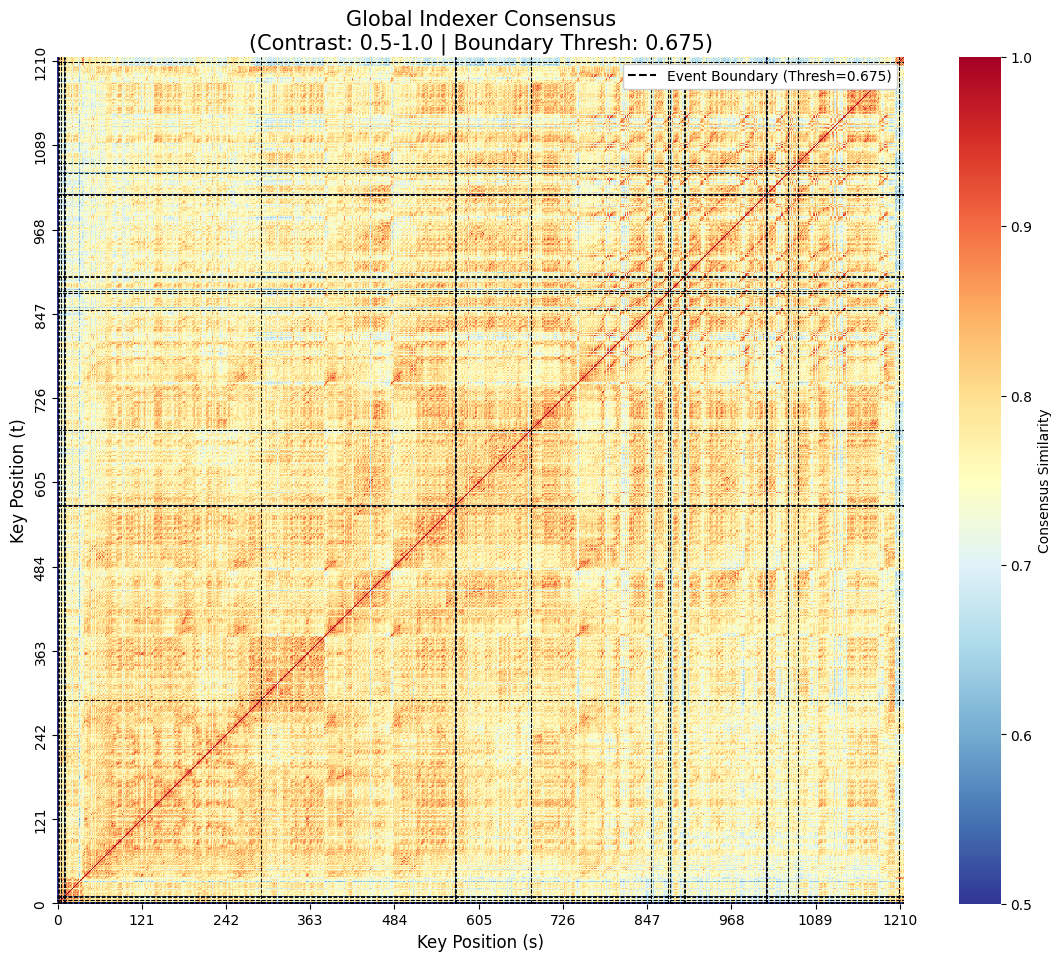

Saved to visualizations/tuned_maps/tuned_indexer.png
Loading processed_data/aggregated_attn_consensus.csv...
Detected 61 boundaries for attention


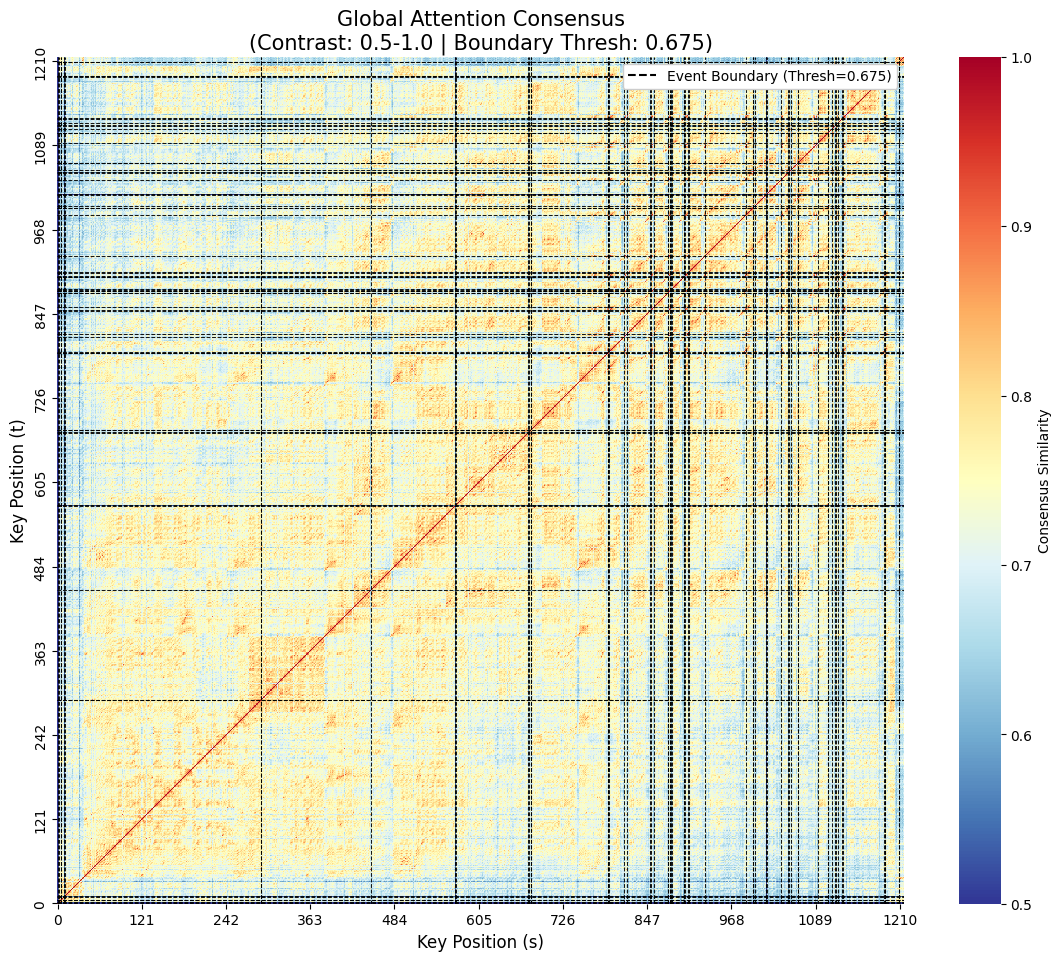

Saved to visualizations/tuned_maps/tuned_attention.png


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- TUNING PARAMETERS ---
PROCESSED_DIR = "processed_data"
OUTPUT_DIR = "visualizations/tuned_maps"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. EVENT BOUNDARY SENSITIVITY
# Lower = More boundaries (more sensitive to small changes)
# Higher = Fewer boundaries (only major shifts detected)
SIMILARITY_THRESHOLD = 0.675 

# 2. COLORMAP CONTRAST
# Adjust these to shift the black/white balance
# VMIN: Values below this are pure White
# VMAX: Values above this are pure Black
VMIN = 0.5  
VMAX = 1.0  

def detect_boundaries(matrix, threshold):
    # Detects where similarity to t-1 drops below threshold
    off_diag = np.diagonal(matrix, offset=-1)
    return [i + 1 for i, score in enumerate(off_diag) if score < threshold]

def plot_tuned_heatmap(csv_path, title, filename_suffix):
    if not os.path.exists(csv_path):
        print(f"Skipping {csv_path} (Not found)")
        return

    print(f"Loading {csv_path}...")
    df = pd.read_csv(csv_path, index_col=0)
    matrix = df.values
    
    # Calculate Boundaries
    boundaries = detect_boundaries(matrix, SIMILARITY_THRESHOLD)
    print(f"Detected {len(boundaries)} boundaries for {filename_suffix}")

    # Plot
    plt.figure(figsize=(14, 11))
    mask = np.triu(np.ones_like(matrix), k=1)
    
    sns.heatmap(
        matrix, 
        # cmap="Greys",
        cmap="RdYlBu_r",
        vmin=VMIN, vmax=VMAX,
        cbar_kws={'label': 'Consensus Similarity'},
        xticklabels=max(1, len(matrix)//10), 
        yticklabels=max(1, len(matrix)//10),
        square=True,
        # mask=mask
    )

    # --- CRITICAL CHANGE: INVERT Y-AXIS ---
    # This puts index 0 at the bottom and index N at the top.
    # The diagonal now runs from Bottom-Left to Top-Right (y=x).
    plt.gca().invert_yaxis()
    # --------------------------------------
    
    # Draw Boundaries
    for b in boundaries:
        plt.axvline(x=b, color='black', linestyle='--', linewidth=0.75, alpha=0.9)
        plt.axhline(y=b, color='black', linestyle='--', linewidth=0.75, alpha=0.9)
            
    # Legend
    plt.plot([], [], color='black', linestyle='--', label=f'Event Boundary (Thresh={SIMILARITY_THRESHOLD})')
    plt.legend(loc='upper right', framealpha=1.0)

    plt.title(f"{title}\n(Contrast: {VMIN}-{VMAX} | Boundary Thresh: {SIMILARITY_THRESHOLD})", fontsize=15)
    plt.xlabel("Key Position (s)", fontsize=12)
    plt.ylabel("Key Position (t)", fontsize=12)
    
    save_path = os.path.join(OUTPUT_DIR, f"tuned_{filename_suffix}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved to {save_path}")

# --- EXECUTE VISUALIZATION ---

# Plot Indexer
plot_tuned_heatmap(
    os.path.join(PROCESSED_DIR, "aggregated_index_consensus.csv"),
    "Global Indexer Consensus",
    "indexer"
)

# Plot Attention
plot_tuned_heatmap(
    os.path.join(PROCESSED_DIR, "aggregated_attn_consensus.csv"),
    "Global Attention Consensus",
    "attention"
)